# Task 2. Quantum circuit to produce the $\frac{1}{\sqrt{2}}( |01> + |10>)$ bell state

The task asks to build a circuit that produces the bell state $\frac{1}{\sqrt{2}}( |01> + |10>)$, and where the parameters of the gates are found using gradient descent. I will use the PennyLane framework to compute the gradient of the circuit. The beginning point for the circuit is the following:

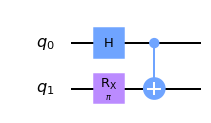

In [1]:
from qiskit import *
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane_cirq import ops as cirq_ops
import matplotlib.pyplot as plt

circ = QuantumCircuit(2)
circ.rx(np.pi,1)
circ.h(0)
circ.cx(0,1)
circ.draw('mpl')

This circuit would give us the required bell state when starting from both qubits in the state |0>. We can express the previous circuit in terms of only Rx, Ry and C-NOT gates in the following way:

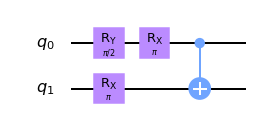

In [2]:
circ = QuantumCircuit(2)
circ.rx(np.pi,1)
circ.ry(np.pi/2,0)
circ.rx(np.pi,0)
circ.cx(0,1)
circ.draw('mpl')

The goal is to start with random angles in the gates and optimize the circuit to produce the $\frac{1}{\sqrt{2}}( |01> + |10>)$ state. We can measure the probability of the |01> and |10> from the previous circuit, but how could we measure the relative phase to make sure we produce the desired bell state? For this, I'll add to the previous circuit a bell state analyzer. A measurement in the Z-basis in this analyzer will output the values (+1,-1) for the qubits 0,1 ONLY if the input state is $\frac{1}{\sqrt{2}}( |01> + |10>)$. Thus, we can add terms related with this two measurement in the cost function in order to make sure the circuit produces the desired state. I will implement the bell state analyzer with the following circuit:

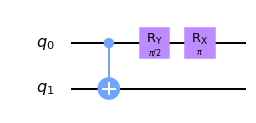

In [15]:
circ = QuantumCircuit(2)
circ.cx(0,1)
circ.ry(np.pi/2,0)
circ.rx(np.pi,0)
circ.draw('mpl')

To implement noise, I used the backend 'mixedsimulator' from CirqOps, making the bits flip with a probability p right before the measurement in both circuits. For the cost function, I used a simple absolute value function. 

---------------Number of shots: 1------------------

Optimized rotation angles (in units of pi): [0.92926499 0.43576491 0.13868762]
Probability of each state in the computational base: [0. 1. 0. 0.]
Result of the bell state analyzer: [ 1. -1.]


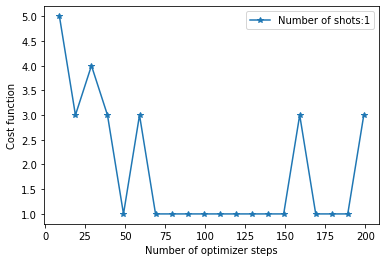

---------------Number of shots: 10------------------

Optimized rotation angles (in units of pi): [1.00505002 0.48842592 0.13462279]
Probability of each state in the computational base: [0.  0.7 0.3 0. ]
Result of the bell state analyzer: [ 1. -1.]


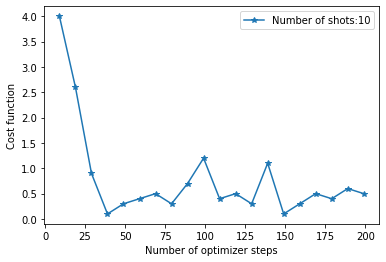

---------------Number of shots: 100------------------

Optimized rotation angles (in units of pi): [0.98644342 0.4777285  0.02278379]
Probability of each state in the computational base: [0.01 0.55 0.39 0.05]
Result of the bell state analyzer: [ 1.   -0.82]


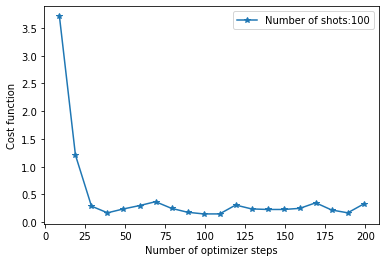

---------------Number of shots: 1000------------------

Optimized rotation angles (in units of pi): [0.99880633 0.49531601 0.02905425]
Probability of each state in the computational base: [0.027 0.486 0.468 0.019]
Result of the bell state analyzer: [ 1.    -0.912]


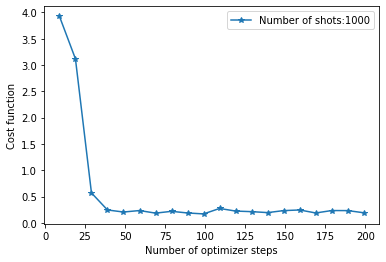

In [16]:
for shot in [1,10,100,1000]: # number of measurements
    
    dev1 = qml.device("cirq.mixedsimulator", wires=2, shots = shot, analytic=False) 
    
    
    #-------------------Building the circuits------------------
    
    p = 0.05 #5% probability of flipping a bit

    
    def ansatz(params): #
        qml.RX(params[0], wires=1) 
        qml.RY(params[1], wires=0) 
        qml.RX(params[2], wires=0) 
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
        qml.CNOT(wires =[0,1]) 
    

    @qml.qnode(dev1) 
    def circuit1(params):
        ansatz(params)
        return qml.probs(wires=[0,1])


    @qml.qnode(dev1) 
    def circuit2(params):  #bell state analyzer
        ansatz(params)
        qml.CNOT(wires =[0,1]) 
        qml.RY(np.pi/2, wires=0) 
        qml.RX(np.pi, wires=0) 
        return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))


    #-----------------Setting up the optimizer--------------
    
      
    def cost(params):  #Cost function 
        cost =  abs(circuit1(params)[0]) + abs(circuit1(params)[3]) + abs(0.5-circuit1(params)[1])+abs(0.5-circuit1(params)[2]) + abs(1-circuit2(params)[0]) + abs(1+circuit2(params)[1])
        return cost

    opt = qml.GradientDescentOptimizer(stepsize=0.1) #Gradient descent
    iteration=200
    iterationlist=[]
    params = np.random.rand(3)/10 #initialize parameters

    costs=[]

    #---------------------------------Training---------------------------------
    
    for i in range(iteration):
        # update the circuit parameters
        params = opt.step(cost, params)
        if (i + 1) % 10 == 0:
            iterationlist.append(i)
            costs.append(cost(params))
            #print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    print(f'---------------Number of shots: {shot}------------------')
    print()
    print("Optimized rotation angles (in units of pi): {}".format(params/np.pi))
    print('Probability of each state in the computational base:',circuit1(params))
    print('Result of the bell state analyzer:', circuit2(params))
    
    plt.plot(iterationlist,costs,'-*', label = f'Number of shots:{shot}')
    plt.legend()
    plt.xlabel('Number of optimizer steps')
    plt.ylabel('Cost function')
    plt.show()
  

We can see that the more shots in the measurements we do, the lower the cost function gets, as we would expect. For 1 shot, results are too random in order to make the optimizer converge, and the produced state is |01>. This makes sense since we are doing only one measuremtent, so the produced state will not be a superposition but rather a pure state. For 1000 shots the algorithm converges very quickly, with the probabilities of getting |01> and |10> being 48.6% and 46.8% respectively, which is very close to the 50/50 we wanted to achieve. The result of the bell state analyzer shows a measurement (+1.0,-0.912) meaning that in fact we are producing quantum states close to the $\frac{1}{\sqrt{2}}( |01> + |10>)$ state.

One may note that the optimized angles do not completely correspond with the angles of the initially proposed circuit (aside from the uncertainties related to the noise and the limited number of measurements). Nevertheless, if we look carefully, we can see that this optimized angles do the same job as the ones I initially proposed. The optimized circuit looks like this:

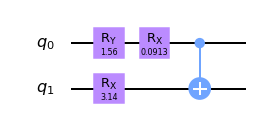

In [17]:
circ = QuantumCircuit(2)
circ.rx(params[0],1)
circ.ry(params[1],0)
circ.rx(params[2],0)
circ.cx(0,1)
circ.draw('mpl')

Specifically, the angle of the second gate applied to the $q_0$ qubit, the Rx gate, tends to 0 instead of tending to $\pi$ as we proposed in the initial circuit. This is because after applying the Ry($\frac{\pi}{2}$) to the $q_0$ qubit, the state of $q_0$ is |+>, i.e., it is oriented in the x direction in the Bloch sphere. Thus, any rotation of that state around the x axis will cause no effect to the state, and the algorithm decided to give the angle of that gate 0 (any other angle would have worked aswell). Therefore, we may conclude again, after the analysis of the optimized circuit, that the output of such circuit will be indeed the $\frac{1}{\sqrt{2}}( |01> + |10>)$ state!